In [113]:
from pyramid.arima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from pandas.plotting import autocorrelation_plot
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox

import util
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import warnings
import itertools
import pyramid
import datetime as dt


warnings.filterwarnings("ignore") 
rcParams['figure.figsize'] = 20, 16

%matplotlib inline


print('numpy version: %r' % np.__version__)
print('pyramid version: %r' % pyramid.__version__)

numpy version: '1.14.0'
pyramid version: '0.6.5'


In [114]:
data, meta = util.read_arf('powersupply.arff');

data = list(map(lambda x: (x[0], x[1], int(x[2])), data))

x = list(filter(lambda x: int(x[2]) == 0, data))

dates = pd.date_range('1995-01-01', periods=len(x), freq='D')

X = pd.DataFrame(x)
X.rename(columns={0: 'main_grid',1: 'other_grid', 2: 'hour'}, inplace=True)
# extract only 0 hour
lst = list(filter(lambda x: x.hour == 0,dates))

lst = lst[:len(lst)-((len(lst) - len(x)))]

X['datetime'] = lst
X.set_index('datetime', inplace = True)

X = X.resample('W-Mon').mean();

X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 179 entries, 1995-01-02 to 1998-06-01
Freq: W-MON
Data columns (total 3 columns):
main_grid     179 non-null float64
other_grid    179 non-null float64
hour          179 non-null int64
dtypes: float64(2), int64(1)
memory usage: 5.6 KB


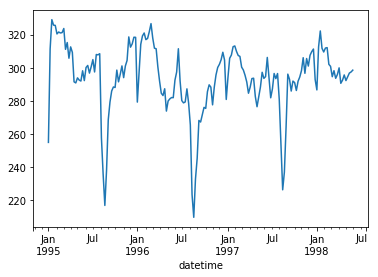

In [115]:
# X[['main_grid', 'other_grid']].plot(figsize=(8, 4))
# plt.show()

x = X['main_grid'] + X['other_grid']

x.plot()
plt.show()

#periods to predict
periods = len(x[x.index.year == 1998]) #+ len(x[x.index.year == 1997])
t = pd.concat([x[x.index.year == 1998]])

# y = x[x.index.year != 1997]
y = x[x.index.year != 1998]


y = pd.Series(y)

# autocorrelation_plot(y);

# result = seasonal_decompose(y, model='additive')

# result.plot()

### Test Stationary

Using rolling mean and std dev we will plot if our data is stationary or non-stationary.


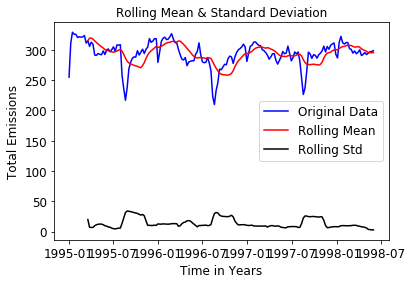

In [116]:
def test_stationary_plot(ts):
    fontsize = 12
    figsize = (12,8)
    rol_mean = ts.rolling(window = 12, center = False).mean()
    rol_std = ts.rolling(window = 12, center = False).std()
    
    plt.plot(ts, color = 'blue',label = 'Original Data')
    plt.plot(rol_mean, color = 'red', label = 'Rolling Mean')
    plt.plot(rol_std, color ='black', label = 'Rolling Std')
    plt.xticks(fontsize = fontsize)
    plt.yticks(fontsize = fontsize)
    
    plt.xlabel('Time in Years', fontsize = fontsize)
    plt.ylabel('Total Emissions', fontsize = fontsize)
    plt.legend(loc='best', fontsize = fontsize)
    plt.title('Rolling Mean & Standard Deviation', fontsize = fontsize)
    plt.show(block= True)


test_stationary_plot(x)

From the plot we can see that our data does not have increased trend overtime, hence our data should be stationary.

In order to confirm that we will run Dicker Fuller test to confirm this hypothesis.

In [117]:
def test_stationary_adfuller(ts, cutoff = 0.01):
    ts_test = adfuller(ts, autolag = 'AIC')
    ts_test_output = pd.Series(ts_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in ts_test[4].items():
        ts_test_output['Critical Value (%s)'%key] = value
    print(ts_test_output)
    
    if ts_test[1] <= cutoff:
        print("Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
        

        
test_stationary_adfuller(x) 

Test Statistic                  -5.145322
p-value                          0.000011
#Lags Used                       1.000000
Number of Observations Used    177.000000
Critical Value (1%)             -3.467845
Critical Value (5%)             -2.878012
Critical Value (10%)            -2.575551
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


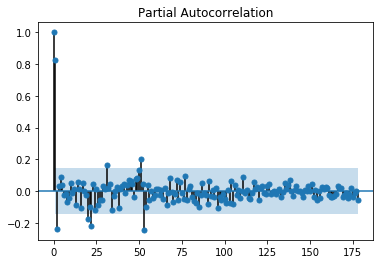

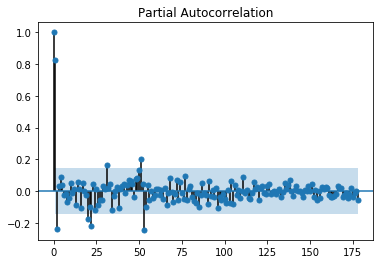

In [118]:
from statsmodels.graphics.tsaplots import plot_pacf

test_result = acorr_ljungbox(x)

plot_pacf(x)

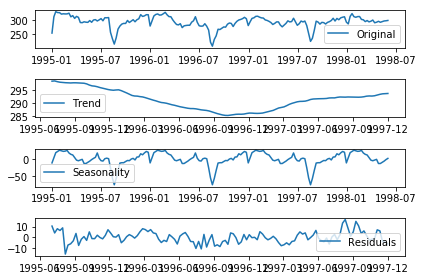

In [119]:
decomposition = seasonal_decompose(x)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(x, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [100]:
p = d = q = range(0, 2) # Define the p, d and q parameters to take any value between 0 and 2
pdq = list(itertools.product(p, d, q)) # Generate all different combinations of p, q and q triplets
pdq_x_QDQs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))] # Generate all different combinations of seasonal p, q and q triplets
print('Examples of Seasonal ARIMA parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], pdq_x_QDQs[1]))
print('SARIMAX: {} x {}'.format(pdq[2], pdq_x_QDQs[2]))

Examples of Seasonal ARIMA parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 1, 0) x (0, 1, 0, 12)


In [102]:
for param in pdq:
    for seasonal_param in pdq_x_QDQs:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=seasonal_param,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1167.643, BIC=1182.924, Fit time=0.416 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=1200.597, BIC=1212.822, Fit time=0.263 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1165.950, BIC=1178.175, Fit time=0.325 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=1166.193, BIC=1181.474, Fit time=0.649 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=1214.860, BIC=1224.029, Fit time=0.077 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=1165.290, BIC=1180.572, Fit time=0.772 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=1166.833, BIC=1185.170, Fit time=0.930 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 2, 12); AIC=1174.915, BIC=1187.140, Fit time=0.525 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_orde

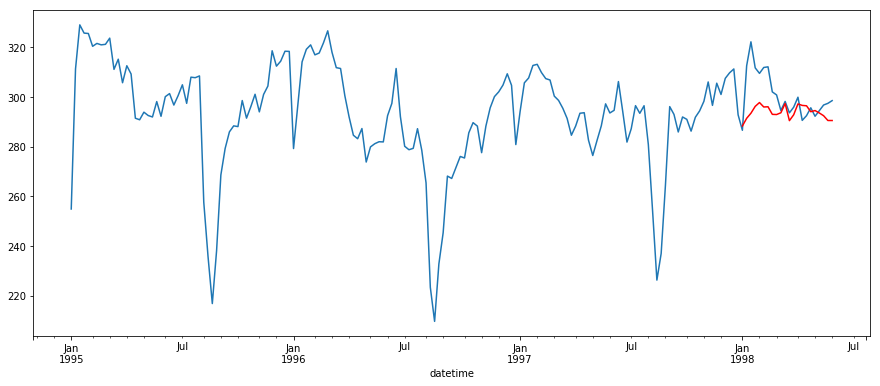

In [121]:
stepwise_fit = auto_arima(y, start_p=1, start_q=1, max_p=5, max_q=5, m=12,
                          start_P=0, seasonal=True, d=1, D=1, trace=True,
                          error_action='ignore',  # don't want to know if an order does not work
                          suppress_warnings=True,  # don't want convergence warnings
                          stepwise=True)  # set to stepwise

print(stepwise_fit.summary())

next_year_prediction= stepwise_fit.predict(n_periods=periods)

forecasted_year_series = pd.Series(next_year_prediction, index=t.index)

true_values = t.values

predicted_values = next_year_prediction;

# mse = ((predicted_values - true_values) ** 2).mean()

mse = mean_squared_error(true_values, predicted_values)
print('The Mean Squared Error {}'.format(round(mse, 2)))

ax = pd.Series(x).plot(figsize=(15, 6))

forecasted_year_series.plot(color='red', ax=ax)
plt.show()

Test MSE: 105.931


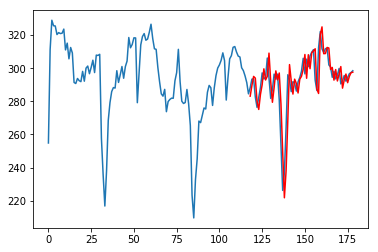

In [124]:
X = pd.Series(x).values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

step_prediction = 1
for t in range(int(len(test)/step_prediction)):
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast(steps = step_prediction)
    
    yhat = [output[0][i] for i in range(step_prediction)]
    
    for num in yhat:
        predictions.append(num)
    
    obs = [test[i] for i in range(t + step_prediction)]
    
    for o in obs:
        history.append(o)
        
#     for yh, ob in zip(yhat, obs):
#         print('predicted=%f, expected=%f' % (yh, ob))
        
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

# plot
plt.plot(X)
plt.plot([(i + len(X) - len(predictions)) for i in range(0, len(predictions))], predictions, color='red')
plt.show()

# 